In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
### Preparing ERA5-Land data ###
'''
1. Following folder structure needs to be maintained
    downloaded
    processed
    scripts
2. Download ERA5-Land in the downloaded folder using the following script
   /work/cmcc/vr25423/Project/AdriaClimPlus/data/data_ERA5-Land/scripts/era5land_download.py
3. Run the scripts in the following order to prepare ERA5-Land data
    1_unpack.py
    2_prepare_t2m.py
    3_prepare_prec.py
    4_prepare_wind.py
    5_prepare_Surf_LW_up.py
    6_prepare_Surf_SW_down.py
    7_prepare_ensemble_mean.py
'''

'\n1. Following folder structure needs to be maintained\n    downloaded\n    processed\n    scripts\n2. Download ERA5-Land in the downloaded folder using the following script\n   /work/cmcc/vr25423/Project/AdriaClimPlus/data/data_ERA5-Land/scripts/era5land_download.py\n3. Run the scripts in the following order to prepare ERA5-Land data\n    1_unpack.py\n    2_prepare_t2m.py\n    3_prepare_prec.py\n    4_prepare_wind.py\n    5_prepare_Surf_LW_up.py\n    6_prepare_Surf_SW_down.py\n    7_prepare_ensemble_mean.py\n'

In [3]:
import math, time, sys, os
import numpy as np
from numpy import sqrt,cos,ma
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc
from   matplotlib.backends.backend_pdf import PdfPages
from   matplotlib.patches import Polygon
from   netCDF4 import Dataset as open_ncfile
from matplotlib.pyplot import figure
import scipy
from scipy.ndimage import convolve1d
from scipy.signal import savgol_coeffs, savgol_filter
from scipy.signal._savitzky_golay import _polyder
from scipy.interpolate import griddata
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import colors
import matplotlib.patches as patches
import datetime
from datetime import date, timedelta
import os
import subprocess
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.metrics import root_mean_squared_error, r2_score
from math import sqrt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [4]:
############################################ Input #######################################
year="1985_2014"
#year="2015_2023"
data_era5="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_ERA5/processed"
data_medcordex="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_MEDCORDEX/processed_SSP245_ERA5"
#data_medcordex="/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_MEDCORDEX/processed_SSP585_ERA5"

# Land sea mask #
lsm_f = open_ncfile("/work/cmcc/vr25423/Project/AdriaClimPlus/data/data_ERA5/downloaded/land_sea_mask.nc","r")
##########################################################################################

In [5]:
def root_mean_squared_error_calc(true, pred):
    squared_diff = (true - pred) ** 2
    mean_squared_error = np.nanmean(squared_diff)
    return np.sqrt(mean_squared_error)

def r2_score_calc(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    ss_res = np.sum((y_true_filtered - y_pred_filtered) ** 2)
    ss_tot = np.sum((y_true_filtered - np.mean(y_true_filtered)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot)
    return r2

def person_calc(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    corr = np.corrcoef(y_true_filtered, y_pred_filtered)[0,1]
    return corr

In [8]:
######################### Total precipitation ############################
lsm=lsm_f.variables["lsm"][0,:,:] # 0 --> sea, above zero --> land.
lsm_thr = 0.5

### winter ###
tp_era5 = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_tp_winter.nc","r")
tp_medcordex = open_ncfile(str(data_medcordex)+"/MEDCORDEX_"+str(year)+"_tp_remap_winter.nc","r")
tp_medcordex_winter=tp_medcordex.variables["RAIN"][-1,:,:]-tp_medcordex.variables["RAIN"][0,:,:]
tp_era5_winter=tp_era5.variables["tp"][0,:,:]*1000
tp_medcordex_remap_winter_m = np.where(np.isnan(tp_era5_winter), np.nan, tp_medcordex_winter)

tp_era5_winter = np.where(lsm > lsm_thr, np.nan, tp_era5_winter)
tp_medcordex_remap_winter_m = np.where(lsm > lsm_thr, np.nan, tp_medcordex_remap_winter_m)


### spring ###
tp_era5 = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_tp_spring.nc","r")
tp_medcordex = open_ncfile(str(data_medcordex)+"/MEDCORDEX_"+str(year)+"_tp_remap_spring.nc","r")
tp_medcordex_spring=tp_medcordex.variables["RAIN"][-1,:,:]-tp_medcordex.variables["RAIN"][0,:,:]
tp_era5_spring=tp_era5.variables["tp"][0,:,:]*1000
tp_medcordex_remap_spring_m = np.where(np.isnan(tp_era5_spring), np.nan, tp_medcordex_spring)

tp_era5_spring = np.where(lsm > lsm_thr, np.nan, tp_era5_spring)
tp_medcordex_remap_spring_m = np.where(lsm > lsm_thr, np.nan, tp_medcordex_remap_spring_m)

### summer ###
tp_era5 = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_tp_summer.nc","r")
tp_medcordex = open_ncfile(str(data_medcordex)+"/MEDCORDEX_"+str(year)+"_tp_remap_summer.nc","r")
tp_medcordex_summer=tp_medcordex.variables["RAIN"][-1,:,:]-tp_medcordex.variables["RAIN"][0,:,:]
tp_era5_summer=tp_era5.variables["tp"][0,:,:]*1000
tp_medcordex_remap_summer_m = np.where(np.isnan(tp_era5_summer), np.nan, tp_medcordex_summer)

tp_era5_summer = np.where(lsm > lsm_thr, np.nan, tp_era5_summer)
tp_medcordex_remap_summer_m = np.where(lsm > lsm_thr, np.nan, tp_medcordex_remap_summer_m)

### autumn ###
tp_era5 = open_ncfile(str(data_era5)+"/ERA5_"+str(year)+"_tp_autumn.nc","r")
tp_medcordex = open_ncfile(str(data_medcordex)+"/MEDCORDEX_"+str(year)+"_tp_remap_autumn.nc","r")
tp_medcordex_autumn=tp_medcordex.variables["RAIN"][-1,:,:]-tp_medcordex.variables["RAIN"][0,:,:]
tp_era5_autumn=tp_era5.variables["tp"][0,:,:]*1000
tp_medcordex_remap_autumn_m = np.where(np.isnan(tp_era5_autumn), np.nan, tp_medcordex_autumn)

tp_era5_autumn = np.where(lsm > lsm_thr, np.nan, tp_era5_autumn)
tp_medcordex_remap_autumn_m = np.where(lsm > lsm_thr, np.nan, tp_medcordex_remap_autumn_m)

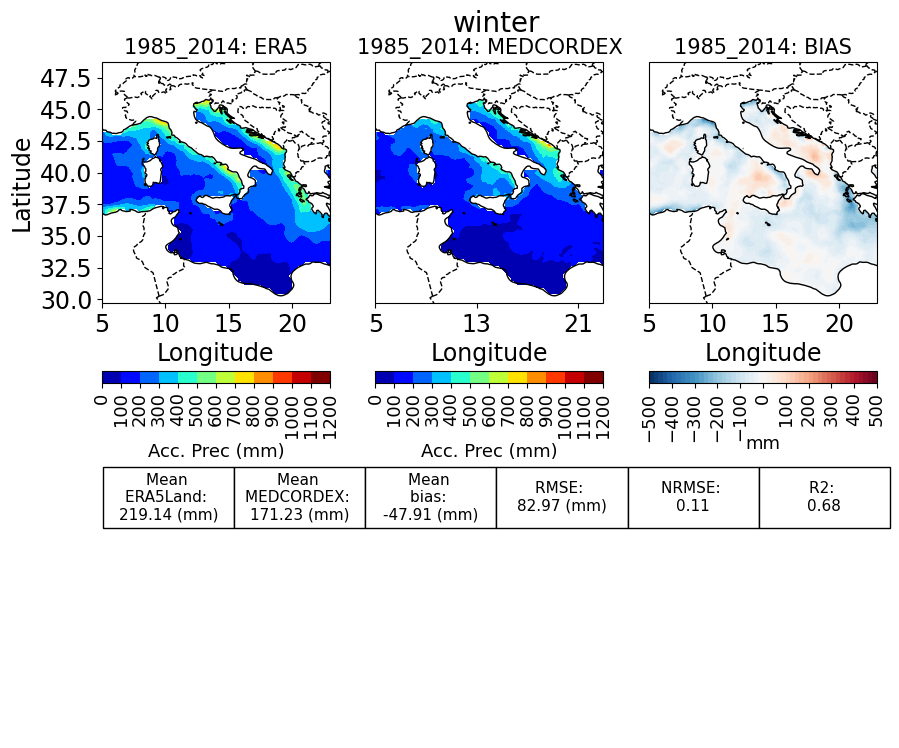

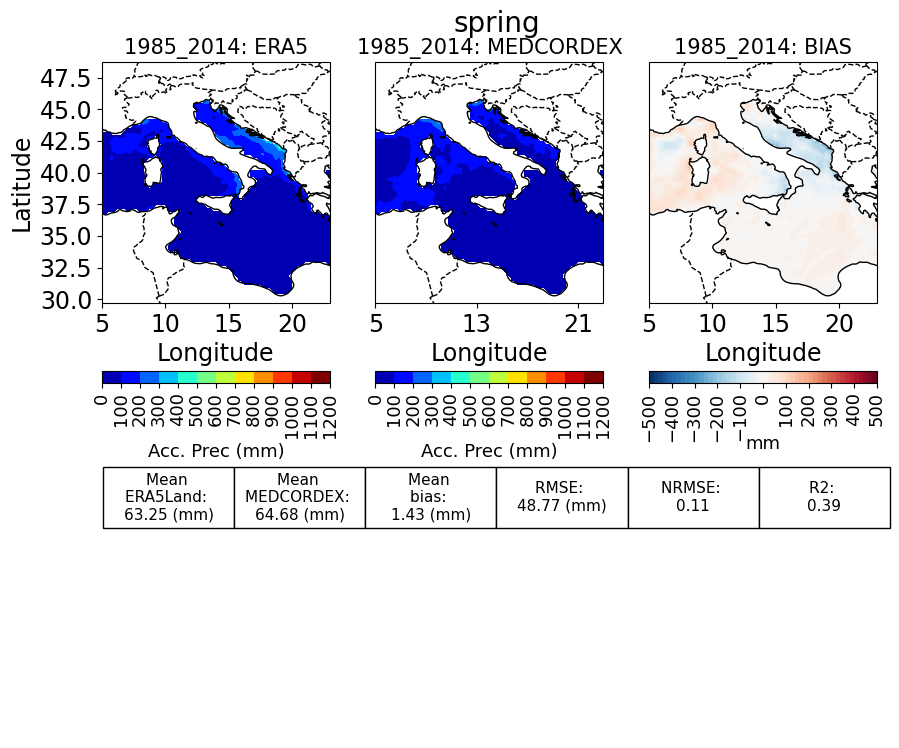

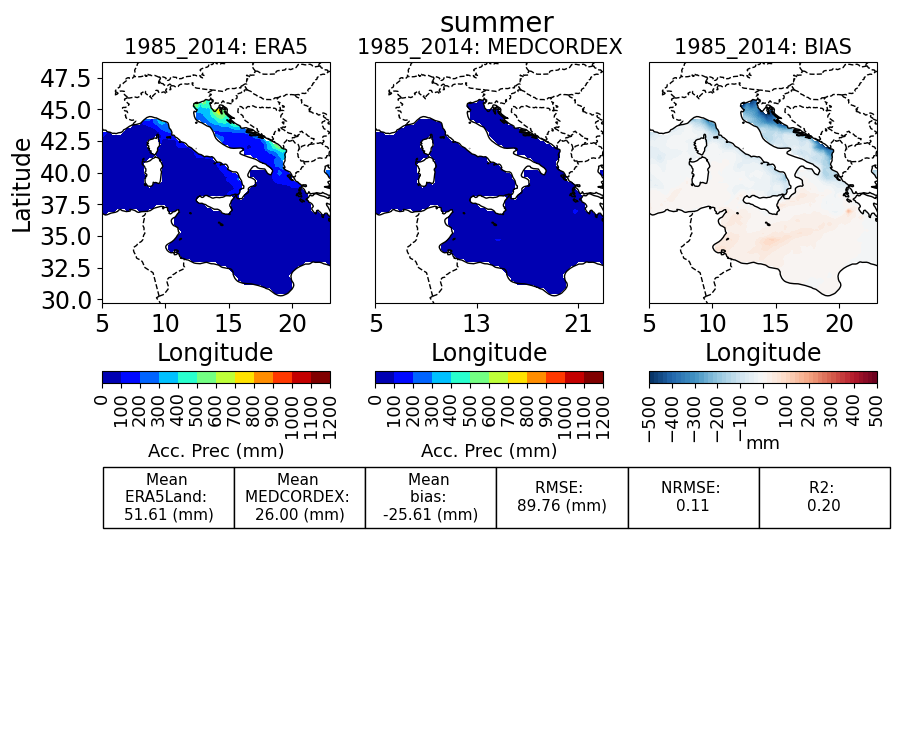

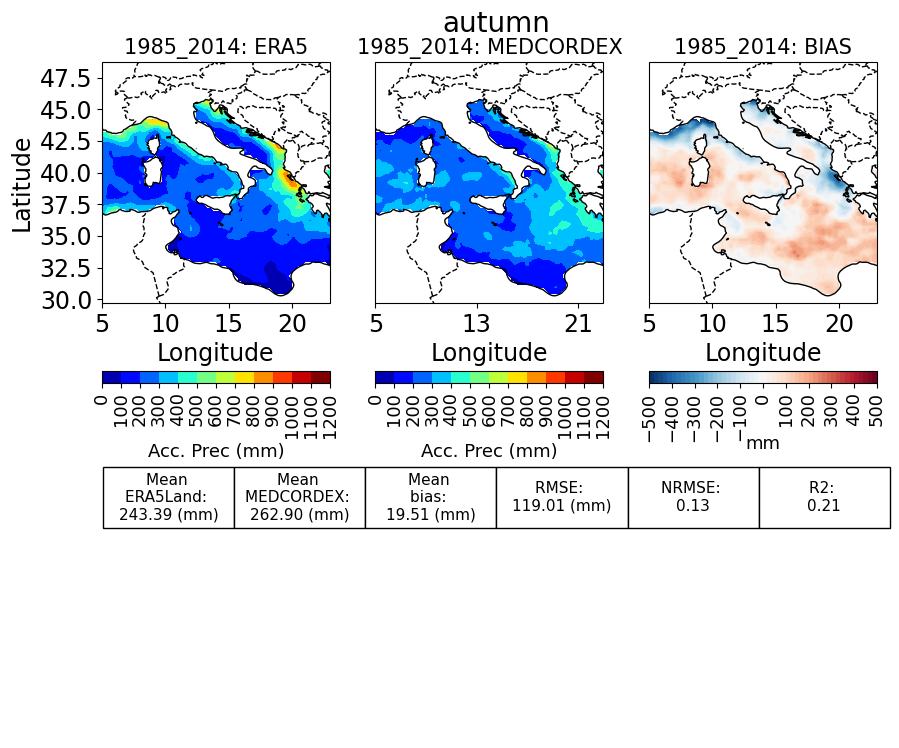

In [16]:
### Plot ###
###### Input ########
#season='winter'
#season='spring'
#season='summer'
#season='autumn'
#####################

seasons = ['winter', 'spring', 'summer', 'autumn']
for season in seasons:
    fig = plt.figure(figsize=(10, 15))
    
    lat=tp_era5.variables["latitude"][:]
    lon=tp_era5.variables["longitude"][:]
    
    min_a=-500
    max_a=500
    min_aa=0
    max_aa=1120
    levels = np.arange(min_a, max_a+20, 20)
    levels_a = np.arange(min_aa, max_aa+100, 100)
    out_lat=tp_era5.variables["latitude"][:]
    out_lon=tp_era5.variables["longitude"][:]
    
    projection=ccrs.PlateCarree()
    
    season_data = {
        'winter_medcordex': tp_medcordex_remap_winter_m,
        'spring_medcordex': tp_medcordex_remap_spring_m,
        'summer_medcordex': tp_medcordex_remap_summer_m,
        'autumn_medcordex': tp_medcordex_remap_autumn_m,
        'winter_era5land': tp_era5_winter,
        'spring_era5land': tp_era5_spring,
        'summer_era5land': tp_era5_summer,
        'autumn_era5land': tp_era5_autumn
    }
    
    
    season_medcordex = season_data[f'{season}_medcordex']
    season_era5land = season_data[f'{season}_era5land']
    
    ax1 = plt.subplot(2, 3, 1, projection=projection)
    plt1=ax1.contourf(out_lon, out_lat, season_era5land, levels=levels_a, vmin=min_aa, vmax=max_aa, cmap="jet")
    ax1.set_title(str(year)+': ERA5',fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=17)
    ax1.set_xlabel("Longitude",fontsize=17)
    ax1.set_ylabel("Latitude",fontsize=17)
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS, linestyle='--')
    ax1.set_xticks(np.arange(5, 25, 5))
    ax1.set_yticks(np.arange(30, 50, 2.5))
    cbar1=plt.colorbar(plt1, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.13)
    cbar1.set_label('Acc. Prec (mm)', fontsize=13)  # Set colorbar label font size
    cbar1.ax.tick_params(labelsize=13)  
    cbar1.set_ticks(np.arange(min_aa, max_aa+100, 100))
    for label in cbar1.ax.get_xticklabels():  # For a horizontal colorbar
        label.set_rotation(90)
    
    
    ax2 = plt.subplot(2, 3, 2, projection=projection)
    plt2=ax2.contourf(out_lon, out_lat, season_medcordex, levels=levels_a, vmin=min_aa, vmax=max_aa, cmap="jet")
    ax2.set_title(str(year)+': MEDCORDEX',fontsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=17)
    ax2.set_xlabel("Longitude",fontsize=17)
    ax2.coastlines()
    ax2.add_feature(cfeature.BORDERS, linestyle='--')
    ax2.set_xticks(np.arange(5, 25, 8), crs=projection)
    ax2.set_yticks([])
    ax2.set_ylabel('')
    cbar2=plt.colorbar(plt2, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.13)
    cbar2.set_label('Acc. Prec (mm)', fontsize=13)  # Set colorbar label font size
    cbar2.ax.tick_params(labelsize=13)  
    cbar2.set_ticks(np.arange(min_aa, max_aa+100, 100))
    for label in cbar2.ax.get_xticklabels():  # For a horizontal colorbar
        label.set_rotation(90)
    
    ax3 = plt.subplot(2, 3, 3, projection=projection)
    bias=season_medcordex-(season_era5land)
    plt3=plt.contourf(out_lon, out_lat, bias, levels=levels, vmin=min_a, vmax=max_a, cmap="RdBu_r")
    ax3.set_title(str(year)+': BIAS',fontsize=15)
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax3.coastlines()
    ax3.set_xlabel("Longitude",fontsize=17)
    ax3.add_feature(cfeature.BORDERS, linestyle='--')
    ax3.set_xticks(np.arange(5, 25, 5), crs=projection)
    ax3.set_yticks([])
    ax3.set_ylabel('')
    cbar3=plt.colorbar(plt3, ax=ax3, orientation='horizontal', fraction=0.046, pad=0.13)
    cbar3.set_label('mm', fontsize=13, labelpad=-5)  # Set colorbar label font size
    cbar3.ax.tick_params(labelsize=13)  
    cbar3.set_ticks(np.arange(min_a, max_a+100, 100))
    for label in cbar3.ax.get_xticklabels():  # For a horizontal colorbar
        label.set_rotation(90)
    
    bias_med_d = np.nanmean(season_medcordex)
    bias_era5land_d = np.nanmean(season_era5land)
    rmse_d = root_mean_squared_error_calc((season_era5land), season_medcordex)
    #nrmse_stdv_d = rmse_d / np.nanstd(season_era5land)
    nrmse_stdv_d = rmse_d / (np.nanmax(season_era5land)-np.nanmin(season_era5land))
    #r2_d = r2_score_calc(season_era5land.flatten(), season_medcordex.flatten())
    
    r2_d = np.square(person_calc(season_era5land.flatten(), season_medcordex.flatten()))
    
    person_calc
    
    ax4 = plt.subplot(2, 3, 4)
    table_data = [[f"Mean \nERA5Land: \n{bias_era5land_d:.2f} (mm)",f"Mean \nMEDCORDEX: \n{bias_med_d:.2f} (mm)", f"Mean \nbias: \n{np.nanmean(bias):.2f} (mm)", f"RMSE: \n{rmse_d:.2f} (mm)", 
                   f"NRMSE: \n{nrmse_stdv_d:.2f}", f"R2: \n{r2_d:.2f}"]]
    table = ax4.table(cellText=table_data, cellLoc='center', loc='center')
    ax4.axis('off')
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(3, 4)  # Adjust the scaling if necessary
    
    # Hide the cell borders to make it consistent with the plots
    for key, cell in table.get_celld().items():
        cell.set_linewidth(1)  # Set the border line width to 0 to remove borders
    pos_ax2 = ax2.get_position()
    ax4.set_position([pos_ax2.x0-0.01, pos_ax2.y0-0.29, pos_ax2.width*1.15, pos_ax2.height*2.0])
    
    plt.title(season,fontsize=20, y=1.45)
    plt.show()